In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import gensim
import spacy
import string
import core.model_utils as model_utils
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [3]:
df = pd.read_json('./../data/polish_translated/emotions/assignments_dataset_pl_with_tokens.json')
df.rename(columns={'emotion': 'label', 'comment': 'text'}, inplace=True)
df

,text,label,tokens,joined_tokens
0,Jak palion zrobi piosenkę to wiadomo co będzie...,0,"[palion, zrobić, piosenka, wiadomo, kanał, poz...",palion zrobić piosenka wiadomo kanał pozdrawia...
1,"Wiem, że palion może tego nigdy nie zobaczyć, ...",0,"[wiedzieć, palion, móc, nie, zobaczyć, zrobić,...",wiedzieć palion móc nie zobaczyć zrobić chcieć...
2,Był kiedyś taki serial : Kasia i Tomek i wedłu...,0,"[kiedyś, serial, kasia, tomek, jesteście, nowo...",kiedyś serial kasia tomek jesteście nowoczesny...
3,Mamy właśnie przykład jak powinna wyglądać pra...,0,"[mieć, przykład, wyglądać, prawdziwy, konferen...",mieć przykład wyglądać prawdziwy konferencja w...
4,Siemka WK teraz moja kolej na nagrodę pozdraw...,0,"[siemka, wk, kolej, nagroda, pozdrawiać]",siemka wk kolej nagroda pozdrawiać
...,...,...,...,...
1327,Uwielbiam twoje firmy zabieram się za oglądani...,0,"[uwielbiam, firma, zabierać, oglądać, pozdrawi...",uwielbiam firma zabierać oglądać pozdrawiać ws...
1328,"Dla mnie ""Film o pszczołach"" był genialny. Zar...",3,"[film, pszczoł, genialny, zarówno, całokształt...",film pszczoł genialny zarówno całokształt swój...
1329,Zawsze o 14.00 odrazu każda sobota jest lepsza...,0,"[14, 00, odraz, sobota, dobry, dzięki, kamil, ...",14 00 odraz sobota dobry dzięki kamil ❤ ️
1330,Zawsze oglądane do końca! La Budda <3,1,"[oglądać, koniec, la, budda, <3]",oglądać koniec la budda <3


In [7]:
test_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
test_dataset

Dataset({
    features: ['text', 'label', 'tokens', 'joined_tokens'],
    num_rows: 1332
})

In [8]:
# Load models
version = "1"
trained_bert = os.path.join("./../trained_models/emotions_pl_bert_5", version)
trained_gpt = os.path.join("./../trained_models/emotions_pl_gpt2_2", version)

bert = tf.keras.models.load_model(trained_bert)
gpt2 = tf.keras.models.load_model(trained_gpt)

In [9]:
# Create BERT tokenizer and collator
bert_checkpoint = "dkleczek/bert-base-polish-uncased-v1"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, model_max_length=512)


def tokenize_for_bert(example):
    return bert_tokenizer(example["text"], truncation=True)


bert_tokenized_test_dataset = test_dataset.map(tokenize_for_bert, batched=True)

bert_input_columns = ["attention_mask", "input_ids", "token_type_ids"]
bert_label_columns = ['label']
bert_batch_size = 16
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, return_tensors="tf")
bert_tf_dataset = model_utils.convert_to_tf_dataset(bert_tokenized_test_dataset, bert_input_columns, bert_label_columns,
                                                    bert_data_collator, bert_batch_size)

Map:   0%|          | 0/1332 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [10]:
# Create GPT2 tokenizer
gpt_checkpoint = MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

gpt2_tokenizer.padding_side = "left"


def tokenize_for_gpt2(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = gpt2_tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


gpt2_tokenized_test_dataset = test_dataset.map(tokenize_for_gpt2, batched=True)

gpt2_input_columns = ["input_ids", "attention_mask"]
gpt2_label_columns = ["label"]
gpt2_batch_size = 16
gpt2_data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="tf")
gpt2_tf_dataset = model_utils.convert_to_tf_dataset(gpt2_tokenized_test_dataset, gpt2_input_columns, gpt2_label_columns,
                                                    gpt2_data_collator, gpt2_batch_size)

Map:   0%|          | 0/1332 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [11]:
def combine_probabilities(model1_probabilities, model2_probabilities, model1_weights, model2_weights):
    weighted_avg_probabilities = (model1_weights * model1_probabilities + model2_weights * model2_probabilities) / (model1_weights + model2_weights)
    normalized_probabilities = weighted_avg_probabilities / np.sum(weighted_avg_probabilities, axis=1, keepdims=True)

    return normalized_probabilities


def hybrid_predict(bert_input, gpt2_input, bert_model, gpt2_model, bert_weights, gpt2_weights, return_classes=True):
    bert_probabilities = model_utils.get_class_preds(bert_model, bert_input, return_classes=False)
    gpt2_probabilities = model_utils.get_class_preds(gpt2_model, gpt2_input, return_classes=False)

    final_output = combine_probabilities(bert_probabilities, gpt2_probabilities, bert_weights, gpt2_weights)
    if return_classes:
        final_output = np.argmax(final_output, axis=1)
    return final_output

In [12]:
bert_weights = np.array([88, 88, 88, 87, 94, 76])
gpt2_weights = np.array([91, 82, 87, 81, 92, 84])


hybrid_preds = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights,
)

hybrid_probas = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights,
    return_classes=False
)

In [13]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=test_dataset['label'],
    class_preds=hybrid_preds,
    average='micro'
)

accuracy = accuracy_score(test_dataset['label'], hybrid_preds)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
loss = loss(test_dataset['label'], hybrid_probas).numpy()

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)
print(f"Accuracy: ", accuracy)
print(f"Loss: ", loss)

Precision score:  0.31681681681681684
Recall score:  0.31681681681681684
F1 score:  0.31681681681681684
Accuracy:  0.31681681681681684
Loss:  2.0366406440734863


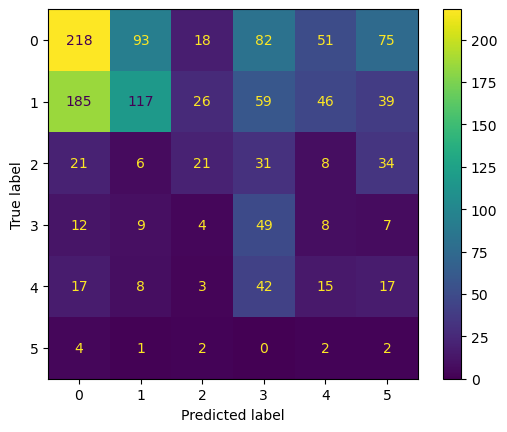

In [14]:
training_name = "only_bert_gpt_bachelor"
figures_dir = "./../documentation/models/emotions_pl_hybrid/figures"

model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=hybrid_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [15]:
model_utils.print_incorrectly_predicted_texts(texts=test_dataset['text'],
                                              class_actual=test_dataset['label'],
                                              class_preds=hybrid_preds,
                                              number_of_incorrect_preds=100)


            BAD PREDICTION:
            - INDEX: 1
            - TEXT: Wiem, że palion może tego nigdy nie zobaczyć, ale jeśli to zrobi, chcę tylko podziękować. Jestem farmaceutą i moja praca była nudna, ale po słuchaniu Twojej muzyki uzależniłem się od syropów z kodeiną i oxów. Od prawie roku robię backdoory opioidow i moje życie jest teraz na własciwych torach. Teraz jeżdżę coupem i codziennie wlewam do kubka uncje lub dwie, twoja muzyka zmieniła mnie na lepsze. Dziękuję bardzo palion
            - PREDICTED VALUE: 3
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 8
            - TEXT: Friz na łyso Świerzy na łyso i Jawor teraz do nich dołączył 
            - PREDICTED VALUE: 3
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 11
            - TEXT: Słoń i Szpaku to jest duet idealny, tego potrzebowałem w tym smutnym jak pizda świecie
            - PREDICTED VALUE: 3
            - CORRECT VALUE

In [16]:
test_df = pd.DataFrame(
    list(zip(test_dataset['text'], test_dataset['label'], hybrid_preds)),
    columns=['text', 'label', 'prediction'])
test_df

,text,label,prediction
0,Jak palion zrobi piosenkę to wiadomo co będzie...,0,1
1,"Wiem, że palion może tego nigdy nie zobaczyć, ...",0,3
2,Był kiedyś taki serial : Kasia i Tomek i wedłu...,0,0
3,Mamy właśnie przykład jak powinna wyglądać pra...,0,0
4,Siemka WK teraz moja kolej na nagrodę pozdraw...,0,0
...,...,...,...
1327,Uwielbiam twoje firmy zabieram się za oglądani...,0,0
1328,"Dla mnie ""Film o pszczołach"" był genialny. Zar...",3,0
1329,Zawsze o 14.00 odrazu każda sobota jest lepsza...,0,0
1330,Zawsze oglądane do końca! La Budda <3,1,3


In [17]:
def map_token_counts(row):
    return len(row['text'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['label'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,text,label,prediction,token_count,count_belonging,correctly_predicted
0,Jak palion zrobi piosenkę to wiadomo co będzie...,0,1,16,12-17,0
1,"Wiem, że palion może tego nigdy nie zobaczyć, ...",0,3,69,66-71,0
2,Był kiedyś taki serial : Kasia i Tomek i wedłu...,0,0,18,18-23,1
3,Mamy właśnie przykład jak powinna wyglądać pra...,0,0,18,18-23,1
4,Siemka WK teraz moja kolej na nagrodę pozdraw...,0,0,8,6-11,1
...,...,...,...,...,...,...
1327,Uwielbiam twoje firmy zabieram się za oglądani...,0,0,9,6-11,1
1328,"Dla mnie ""Film o pszczołach"" był genialny. Zar...",3,0,16,12-17,0
1329,Zawsze o 14.00 odrazu każda sobota jest lepsza...,0,0,11,6-11,1
1330,Zawsze oglądane do końca! La Budda <3,1,3,7,6-11,0


In [18]:
test_df = test_df.drop(test_df[test_df.token_count > 41].index)

In [19]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

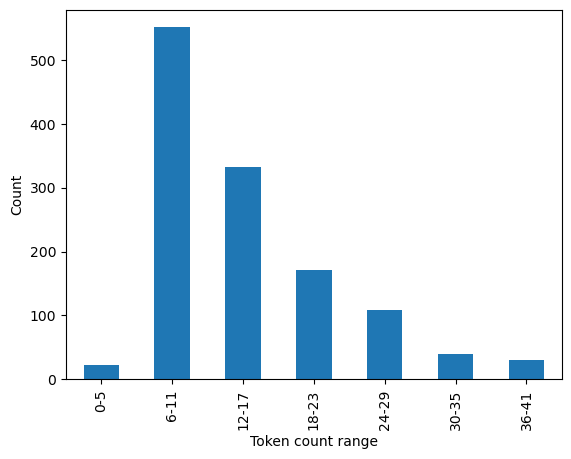

In [20]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [21]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0, '24-29': 0, '30-35': 0, '36-41': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0., '24-29': 0., '30-35': 0., '36-41': 0.}

In [22]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 8, '6-11': 191, '12-17': 94, '18-23': 59, '24-29': 31, '30-35': 13, '36-41': 5}
Element count:  {'0-5': 22, '6-11': 551, '12-17': 332, '18-23': 171, '24-29': 108, '30-35': 40, '36-41': 30}
Accuracies:  {'0-5': 0.36363636363636365, '6-11': 0.3466424682395644, '12-17': 0.28313253012048195, '18-23': 0.34502923976608185, '24-29': 0.28703703703703703, '30-35': 0.325, '36-41': 0.16666666666666666}


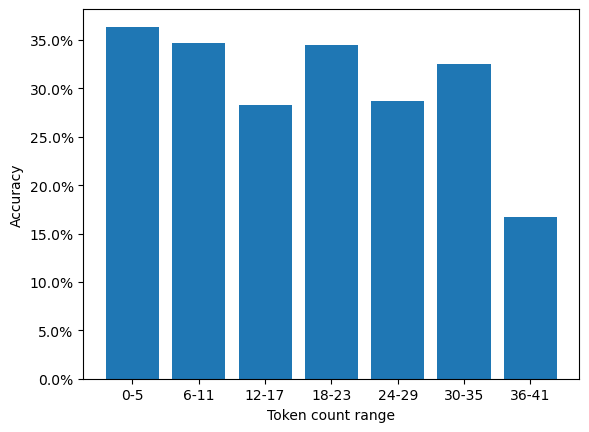

In [23]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23', '24-29', '30-35', '36-41'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()